# Lip Reader

## Installing and Importing Dependencies

1. we are using opencv to preprocess our data
2. matplotlib is used to see the outputs of the preprocessed videos
3. imageio to see some frames stacked together
4. gdown to download the dataset
5. Tensorflow to build the deep neural network
6. importing os to make it easier to traverse the file systems
7. we will use the tensorflow data pipeline usingtf.data API

In [ ]:
%pip install opencv-python matplotlib imageio gdown tensorflow

In [1]:
import os
import cv2
import tensorflow as tf 
import numpy as np 
from typing import List
from matplotlib import pyplot as plt 
import imageio

preventing the exponential growth of memory, when we are running using our GPU
if GPU are present it will be running on a GPU else ot will pass

In [34]:
physical_devices = tf.config.list_physical_devices('GPU')
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [ ]:
tf.config.list_physical_devices('GPU')

## Build Data Loading Functions    

we will be building two data loading function
1. to load up the videos
2. preprocess the annotations
3. dataset is an extract of actual grid dataset, made for lip reading models

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

this dataset has only one speaker, the original one has 34 different speakers

In [2]:
def load_video(path:str)-> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret,frame =cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) 
        # isolating the mouth region
        # there is a specific way of doing this using a faced detector
        # this is used in the lipnet paper
        # here it is done statically
    cap.release()

    # calculating the mean and the standard deviation of the images and the standardardizing them
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

now defining the vocab

In [3]:
vocab=[x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
# StringLookup to convert the characters to numbers and numbers tp characters
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True
)

# what is does is it is tokenizing and returning that value of index
# we will pass this data to our loss function, to be able to calculate our overall loss
# becauseour model will be returing the one hot encoded versionof this

print(
    f"the vocabulary is {char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)


the vocabulary is ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [5]:
def load_alignments(path:str)->List[str]:
    with open(path,'r') as f:
        lines = f.readlines()
    tokens=[]
    for line in lines:
        line =line.split()
        if line[2]!='sil':
            tokens=[*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]
 

In [6]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)

    return frames,alignments

In [35]:
# testing on a test path
test_path='.\\data\\s1\\bbal6n.mpg'

In [36]:
frames,alignments= load_data(tf.convert_to_tensor(test_path)) # this convert a raw string to tensorflow tensor

this is 75 frame in length, 46 pixels high and 140 pixels in width and 1 channel

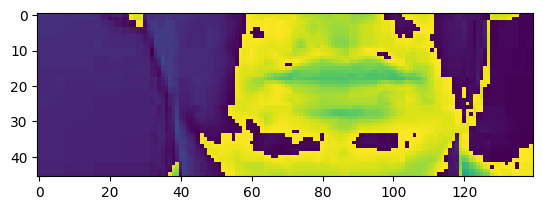

In [37]:
plt.imshow(frames[0]) # to 

In [38]:
# what he is saying is, in decoded format 
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [7]:
# wrapped it inside a mapable function which allow us to return back (tf.float32,tf.int64)
# and we will also be able to use our raw string processing
# required in tensorflow data pipelines
# for pure string processing we need to wrap it in py_function
def mappable_function(path:str)->List[str]:
    result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

## Create Data Pipeline

we need to build a data pipeline to train the deep learning model, tf will draw random samples from the dataset inorder to complete one training set

In [8]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))

# we are batching into group sizes of 2, i.e it will have two videos and 2 sets of alignments
# we ensure that each video has only 75 frames, we do not pad for alignment
# and we have 40 tokens for each of our alignments, if less taht 40 then it is padded out to 0
data = data.prefetch(tf.data.AUTOTUNE)
# to ensure we optimize our data pipeline so that we are loading or preloading as our machine
# learning model is stilee training

# Added for split 
train = data.take(450)
test = data.skip(450)

In [39]:
frames,alignments=data.as_numpy_iterator().next()

In [40]:
# testing for the values of each frame 
test_itr=data.as_numpy_iterator()
val=test_itr.next()

In [ ]:
# imageio.mimsave('./animation.gif',val[0][1],fps=10)
# as we have got two sets of video in each batch, so this will pick up the second one

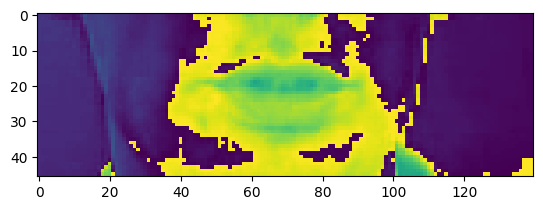

In [41]:
plt.imshow(val[0][0][34])
# 0:videos, 0: ist video of of the batch of 2, 0: the first frame of the video

In [42]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green at s three soon'>

## Design the Deep Neural Network

using 3D convolutions to pass the videos and then condense it down to a classification dense layer
which predicts characters
we will use a special loss function called CTC AKA connectionist temporal classification
to handle this output
It works well when we have word transcriptions that arent specifically aligned to frames, given the
structure, this model is likely to repeat the same letter or word multiple times 
If we use a standard cross entropy loss functionthis will look like our mode is way out
CTC is built for it and reduces the duplicate using a special token

As we said that our data was aligned, but eventually subbing out the data that we create, it's
way more cost effective to use non-align data

In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler #learning fast intially and then slow down

In [43]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [10]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))
# this is going to allow us to have 75inputs into our LSTM neural network
# that we eventually willoutput 75 units which represents out tesxt based characters
# return_sequence ensure that theLSTM do not return single but all 75

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

# our output should be 
# 75,41
# this represent we will recieve one output per frame we pass through 
# and 41 is he one hot encoded representation of our final output

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [44]:
yhat=model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [45]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([12, 12,  1, 25, 39, 39,  7, 18,  5, 40,  5, 14, 39, 39,  1, 20, 39,
       39, 39, 19, 39, 39, 39, 20,  8, 18,  5, 40,  5, 40, 39, 39, 39, 19,
       19, 19, 15, 40, 15, 40, 14, 14, 14, 14, 14, 14,  0, 40,  0, 40,  0,
       40,  0, 40,  0, 40,  0, 40,  0, 40,  0, 40,  0, 40,  0, 40,  0, 40,
        0, 40,  0, 40,  0, 40,  0], dtype=int64)>

In [46]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'llay  green  at   l   nine    ssoonnnnn'>

## Setup Training Options and Train

In [12]:
# defining the learning rate scheduler
# it gives a learning rate of whatever we are passing through
def scheduler(epoch,lr):
    if epoch<30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [13]:
# credits to Automatic Speech recognition model using CTC on keras
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # imput_length 75, label_length= 40
    return loss

In [14]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [15]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=CTCLoss)

In [16]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
# it defines where we will be saving our model
# we have to save our weights
# means we need to redefine the ml model to load up these weights

In [17]:
schedule_callback = LearningRateScheduler(scheduler)
# to drop our learning rate at each epoch

In [18]:
example_callback = ProduceExample(test)
# to see prediction after each epoch to see how well the model is getting trained

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

## Make a prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'

In [ ]:
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [20]:
model.load_weights('models/checkpoint')

In [21]:
test_data = data.as_numpy_iterator()

In [22]:
sample = test_data.next()

In [23]:
yhat = model.predict(sample[0])

1/1 [==============================] - 5s 5s/step


In [24]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white by d seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z four now'>]

In [25]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [26]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white by d seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z four now'>]

## Test on a video

In [27]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [28]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [29]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 990ms/step


In [30]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [31]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]